# Final project: Time-series data and application to stock markets {-}


In [533]:
# Load libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: NASDAQ Stock Price Prediction 

In [570]:
import os 
# Get the list of all files and directories 
# in the root directory 
path = 'data-nasdaq/csv/'
dir_list = os.listdir(path) 
print("Files and directories in", path, ":") 
# print the list 
print(dir_list) 

Files and directories in data-nasdaq/csv/ :
['CSCO.csv', 'BIOS.csv', 'CSBK.csv', 'SBGI.csv', 'UFCS.csv', 'AIRT.csv', 'ISSC.csv', 'KNDI.csv', 'BCMXY.csv', 'TRNS.csv', 'ARII.csv', 'AEIS.csv', 'TROW.csv', 'ISRG.csv', 'FEIM.csv', 'LECO.csv', 'VCYT.csv', 'ORRF.csv', 'BLDP.csv', 'RMGN.csv', 'CHCO.csv', 'SPOK.csv', 'MGEE.csv', 'AMSC.csv', 'SCYX.csv', 'ASYS.csv', 'AFAM.csv', 'HAFC.csv', 'ADTN.csv', 'JVA.csv', 'AVHI.csv', 'OFLX.csv', 'DRRX.csv', 'BV.csv', 'CNBZ.csv', 'ASTC.csv', 'HOV.csv', 'NBIX.csv', 'VRTX.csv', 'GGAL.csv', 'GILD.csv', 'SLM.csv', 'AMKR.csv', 'CHY.csv', 'TAYD.csv', 'IPAS.csv', 'TATT.csv', 'WSTG.csv', 'PFMT.csv', 'EQIX.csv', 'GURE.csv', 'QUIK.csv', 'PODD.csv', 'IPAR.csv', 'AMSWA.csv', 'FORM.csv', 'CPIX.csv', 'V.csv', 'QRVO.csv', 'GEOS.csv', 'IRMD.csv', 'CS.csv', 'HFBL.csv', 'AVEO.csv', 'MCRI.csv', 'SWKS.csv', 'FRPT.csv', 'TBPH.csv', 'PPSI.csv', 'IHD.csv', 'LPTH.csv', 'ENPH.csv', 'BEAT.csv', 'MHLD.csv', 'OIIM.csv', 'BUR.csv', 'APEI.csv', 'SKYAY.csv', 'BPOP.csv', 'ALCO.csv', 'ICUI

In [628]:
# Split the dataset into time windows to get data samples.
root_path = 'data-nasdaq/csv/'

def load_data(symbol): 
    filename = root_path + symbol +'.csv'
    df = pd.read_csv(filename)
    return df

def get_samples(df, window_size, feat, target_pred=1): 
    X_data = []
    y_data = []
    if (feat == "open"):
        feat_index = 2

    if (feat == "close"):
        feat_index= 4
        
    if (feat == "adjusted-close"): 
        feat_index = 5
        
    i = 0 
    while i < (len(df) - window_size - target_pred):
        X_data.append(df.iloc[i:i + window_size,feat_index].to_numpy())
        y_data.append(df.iloc[i + window_size:i + window_size + target_pred, feat_index].to_numpy())
        i += target_pred
    return X_data, y_data

def preprocessing(X_data, y_data, window_size):
    # Import the library
    from sklearn.model_selection import train_test_split

    # Split data into train, val and test. 
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Convert from lists to Numpy arrays for reshaping purpose
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)

    # Reshape the numpy array to fit the neural network input shape requirement
    X_train = X_train.reshape(X_train.shape[0], window_size, 1)
    X_val = X_val.reshape(X_val.shape[0], window_size, 1)
    X_test = X_test.reshape(X_test.shape[0], window_size, 1)

    # Print shape of the training, validation and test set
    # print("Shape of training set: ", X_train.shape, "label shape:", y_train.shape)
    # print("Shape of validation set: ", X_val.shape, "label shape", y_val.shape)
    # print("Shape of test set: ", X_test.shape, "label shape:", y_test.shape)
    return X_train, X_test, X_val, y_train, y_test, y_val

def norm_data(X, y):
    X_norm = X.copy()
    y_norm = y.copy()
    for i in range(0, len(X)):
        min_feature = np.min(X[i])
        max_feature = np.max(X[i])
        X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
        y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
    return X_norm, y_norm

def visualize_train_test_split(df, company_name, feat, pred_time):
    # Visualize the training, validation and test set
    df_plot = df[feat]
    df_plot = df_plot.reset_index(drop=False)

    # Get lengths of the three subsets
    size_train = X_train.shape[0] * pred_time
    size_val = X_val.shape[0] * pred_time
    size_test = X_test.shape[0] * pred_time

    # Plot the subset splits
    ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
    df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
    df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
    ax.set_title("Stock trend of " + company_name)
    plt.xlabel('Time (days)')
    plt.ylabel(feat + 'price in $')
    plt.axvline(x=size_train, color='black', linestyle='--')
    plt.axvline(x=size_train+size_val, color='black', linestyle='--')
    plt.show()
    
def train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time): 
    import tensorflow as tf
    from tensorflow.keras.layers import LSTM, Flatten, Dense, Cropping1D, Input
    model = tf.keras.Sequential()
    model.add(Input(shape=(window_size, 1)))
    model.add(LSTM(units=128, return_sequences=True))  # Output dimension of LSTM layer
    model.add(Dense(1))
    model.add(Cropping1D(cropping=(window_size - pred_time, 0)))
    # Compile the model
    model.compile(optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    # Train the model
    model.fit(X_train_norm, y_train_norm, epochs=15, verbose=0)
    loss, mse = model.evaluate(X_val_norm, y_val_norm, verbose=0)
    return model, loss, mse

def test_model(model, X_test, y_test, plot=False, verbose=1):
    
    X_test_norm, y_test_norm = norm_data(X_test, y_test)
        
    from sklearn.metrics import mean_squared_error
    # Get prediction on the test data
    y_pred_norm = model.predict(X_test_norm, verbose=verbose)
    y_pred_norm_flatten = np.zeros((y_pred_norm.shape[0], y_pred_norm.shape[1]))
    for i in range(y_pred_norm.shape[0]):
        y_pred_norm_flatten[i] = y_pred_norm[i].flatten()
    mse = mean_squared_error(y_pred_norm_flatten, y_test_norm)
    print("MSE on the test set: ", mse)
    
    y_pred_denorm = y_pred_norm_flatten.copy()
    
    for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
        min_feature = np.min(X_test[i])
        max_feature = np.max(X_test[i])
        y_pred_denorm[i] = y_pred_norm_flatten[i] * (max_feature - min_feature) + min_feature
    
    y_pred_denorm = y_pred_denorm.flatten()
    y_test_flat = y_test.flatten()
    if plot: 
        # Visualize predited stock price versus real stock price
        plt.figure(figsize=(16, 8), dpi=300)
        plt.plot(y_pred_denorm, label='Predicted price')
        plt.plot(y_test_flat, label='Real price')
        plt.title('Stock trend prediction in one day', fontsize=16)
        plt.xlabel('Time (days)', fontsize=14)
        plt.ylabel('Open price in $', fontsize=14)
        plt.grid() # Add grid
        plt.legend() # Add legend
        plt.show()
    return mse 

## Exploratory Questions: 

1. What is the stock trend of this company 
2. How does the price change in different time windows? (1 day, 7 days, 15 days, 1 month)

Using example of 1 chosen company, I will visualize how the opening, closing and adjusted close price changed in different time windows

In [525]:
#Try with NVDIA - ticker: NVDA
root_path = 'data-nasdaq/csv/'

def load_data(symbol): 
    filename = root_path + symbol +'.csv'
    df = pd.read_csv(filename)
    return df

#Test
company = 'NVDA'
sample = load_data(company)
sample.tail(5)

,Date,Low,Open,Volume,High,Close,Adjusted Close
6008,06-12-2022,158.190002,165.300003,35269400,165.729996,159.869995,159.869995
6009,07-12-2022,156.669998,157.720001,37238800,161.860001,161.199997,161.199997
6010,08-12-2022,159.589996,162.729996,51545600,171.789993,171.690002,171.690002
6011,09-12-2022,169.750000,171.600006,46509500,175.830002,170.009995,170.009995
6012,12-12-2022,167.970001,170.369995,17144332,172.639999,171.285004,171.285004


In [499]:
sample["Date Time"] = pd.to_datetime(sample['Date'], dayfirst=True)

In [503]:
sample_2022 = sample[sample['Date Time'] > '01-01-2022']

In [507]:
def visualize_change(df, feature): 
    prices = df[feature]
    time_windows = [7, 15, 30]
    all_mas = []
    for time in time_windows: 
        ma = prices.rolling(time).mean()
        all_mas.append(ma)
        
    fig, axs = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    axs[0, 0].plot(df['Date'], df[feature])
    axs[0, 0].set_title('Changes by each days')
    axs[0, 1].plot(df['Date'], all_mas[0])
    axs[0, 1].set_title('Moving Average for 7 days')
    axs[1, 0].plot(df['Date'], all_mas[1])
    axs[1, 0].set_title('Moving Average for 15 days')
    axs[1, 1].plot(df['Date'], all_mas[2])
    axs[1, 1].set_title('Moving Average for 1 month')
    fig

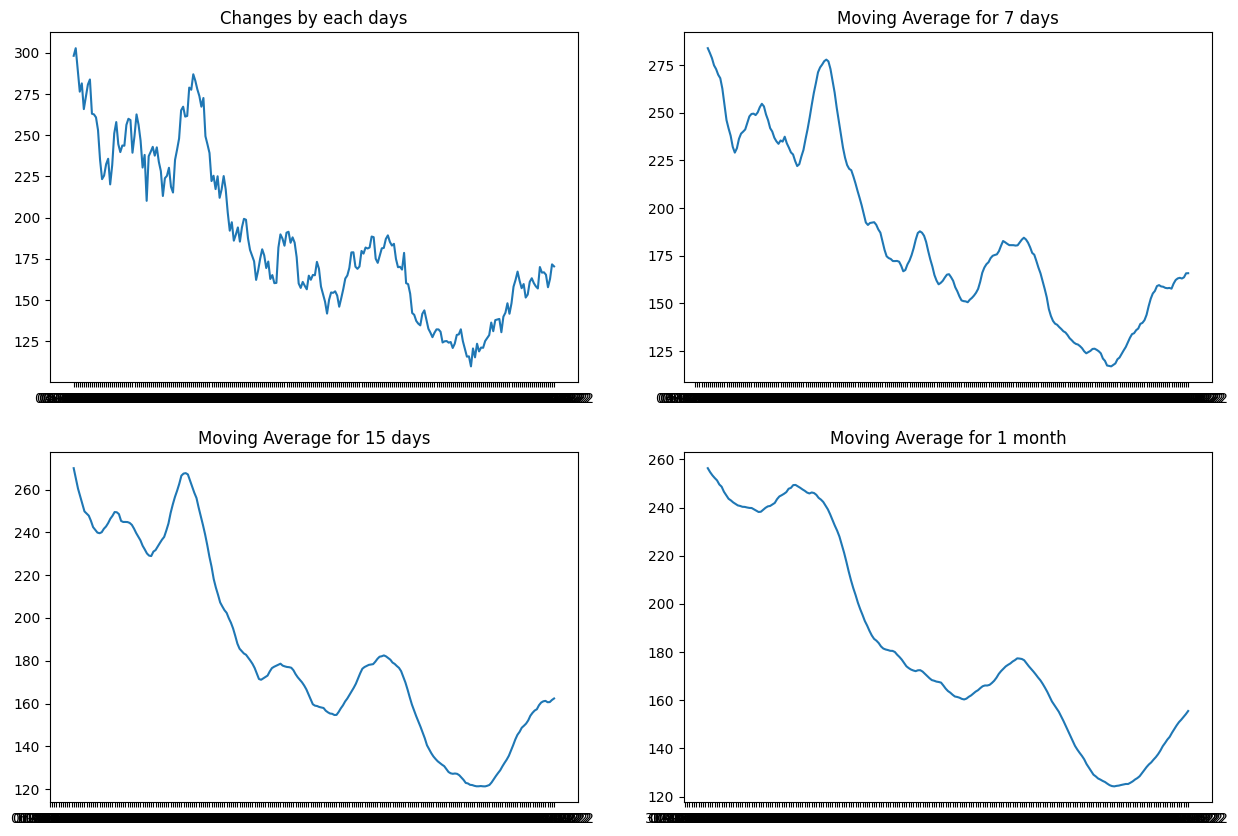

In [508]:
visualize_change(sample_2022, "Open")

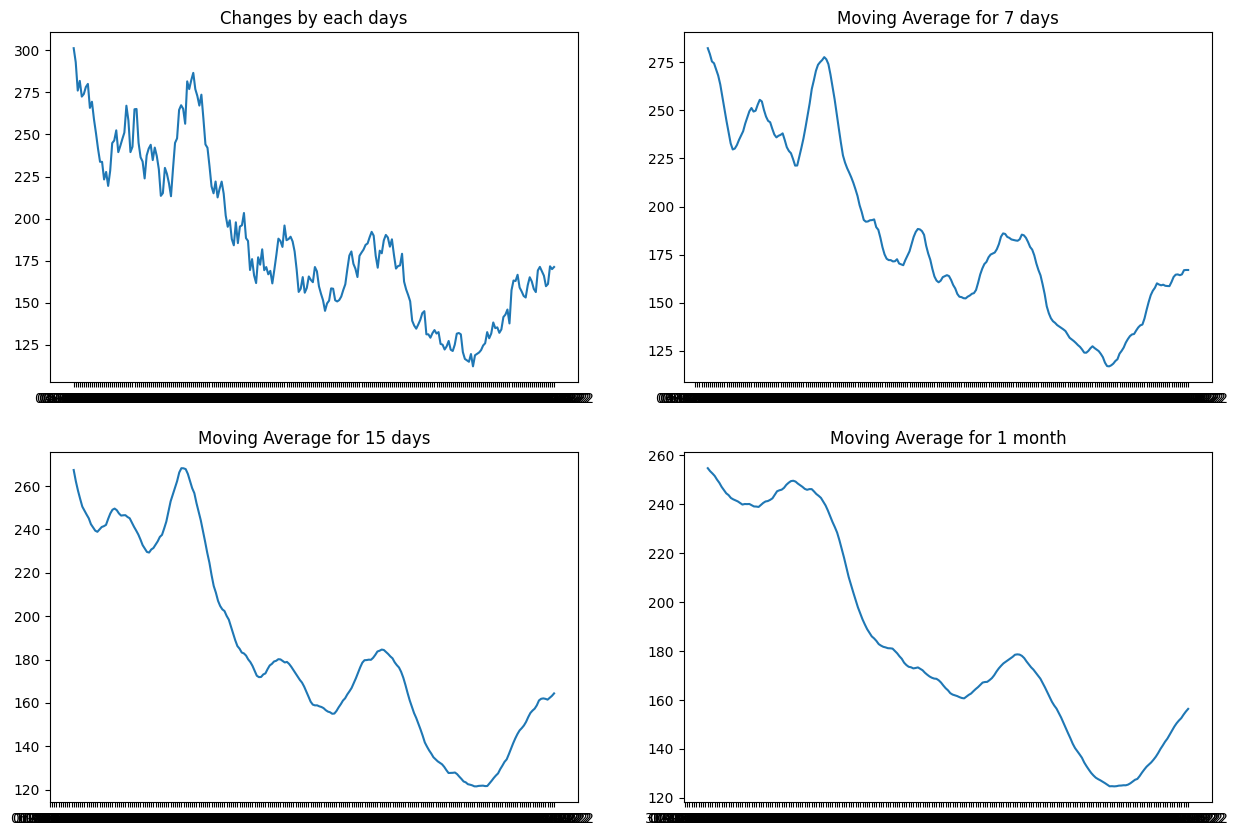

In [509]:
visualize_change(sample_2022, "Close")

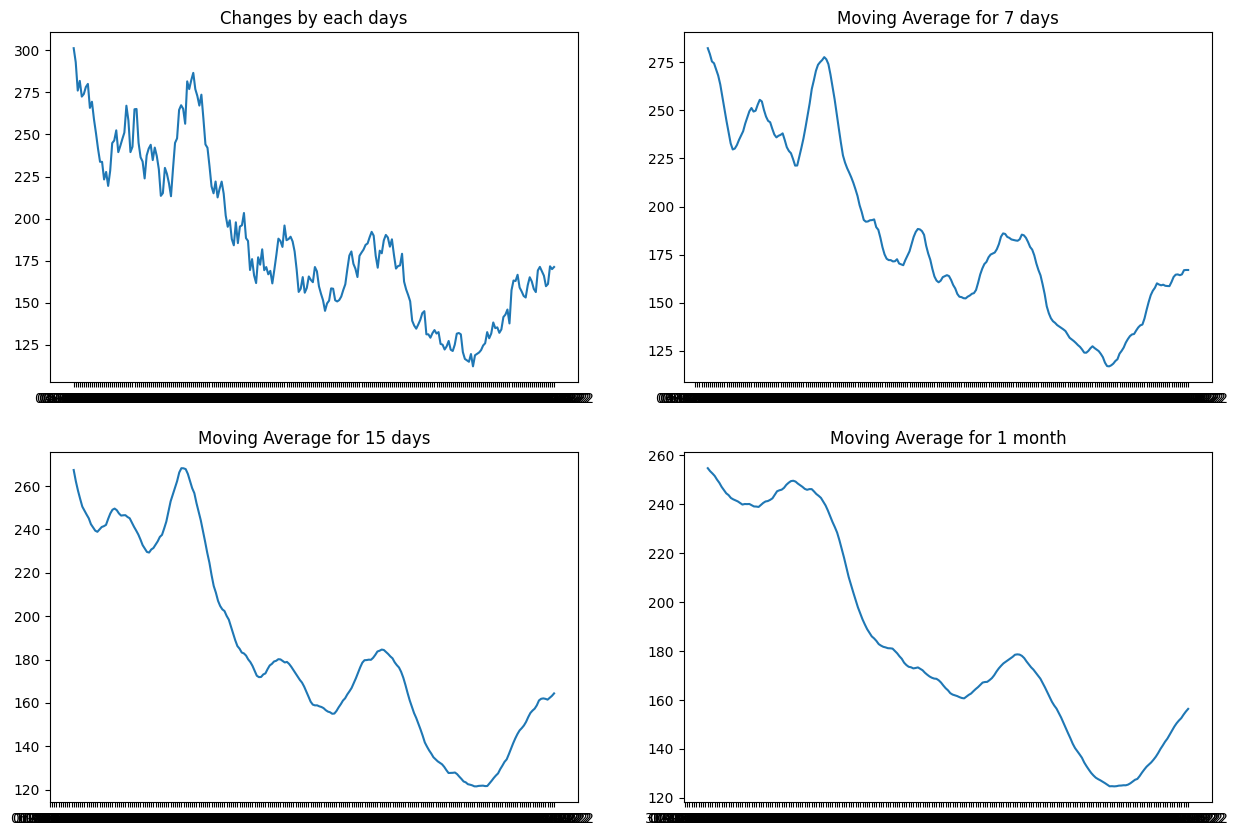

In [510]:
visualize_change(sample_2022, "Adjusted Close")

## Run LSTM Model on Sample data

Run price prediction for adjusted close price on different time windows and prediction periods

In [556]:
window_sizes = [30, 60, 120]
pred_time = 7
val_losses = []
val_MSEs = []
models = []
test_MSEs = []

6/6 [==============================] - 1s 34ms/step
MSE on the test set:  0.20683531219350865


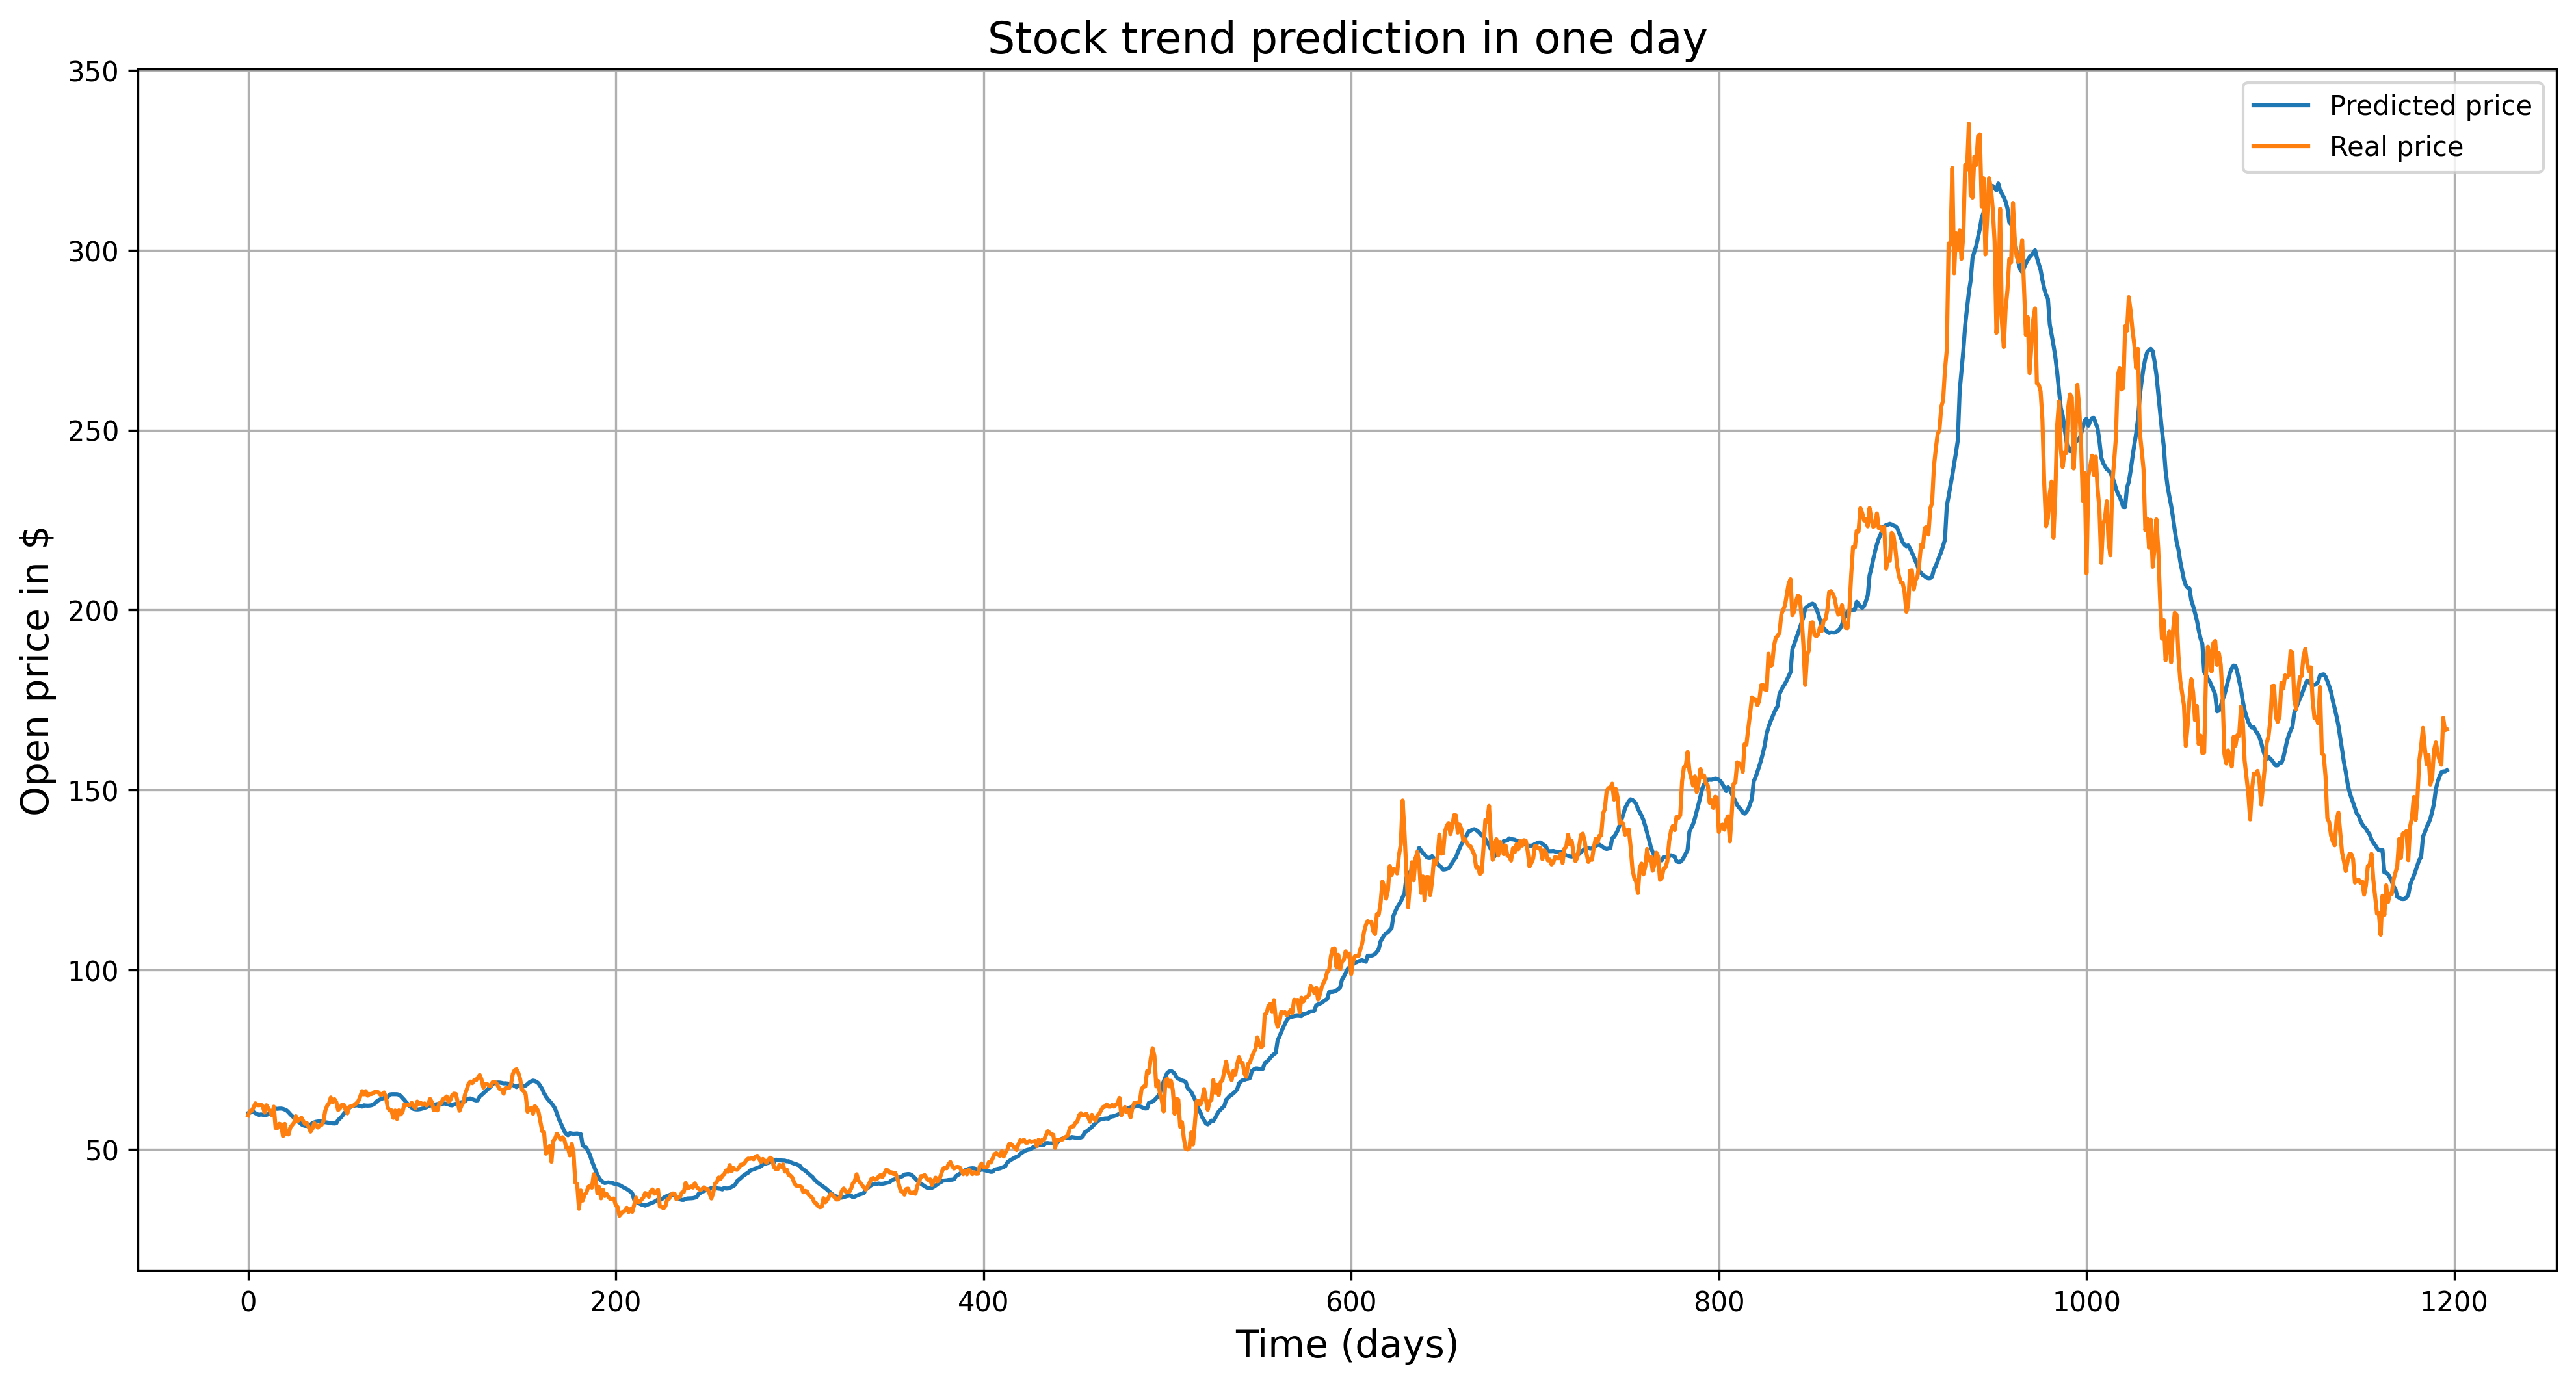

6/6 [==============================] - 1s 42ms/step
MSE on the test set:  0.11503071208437919


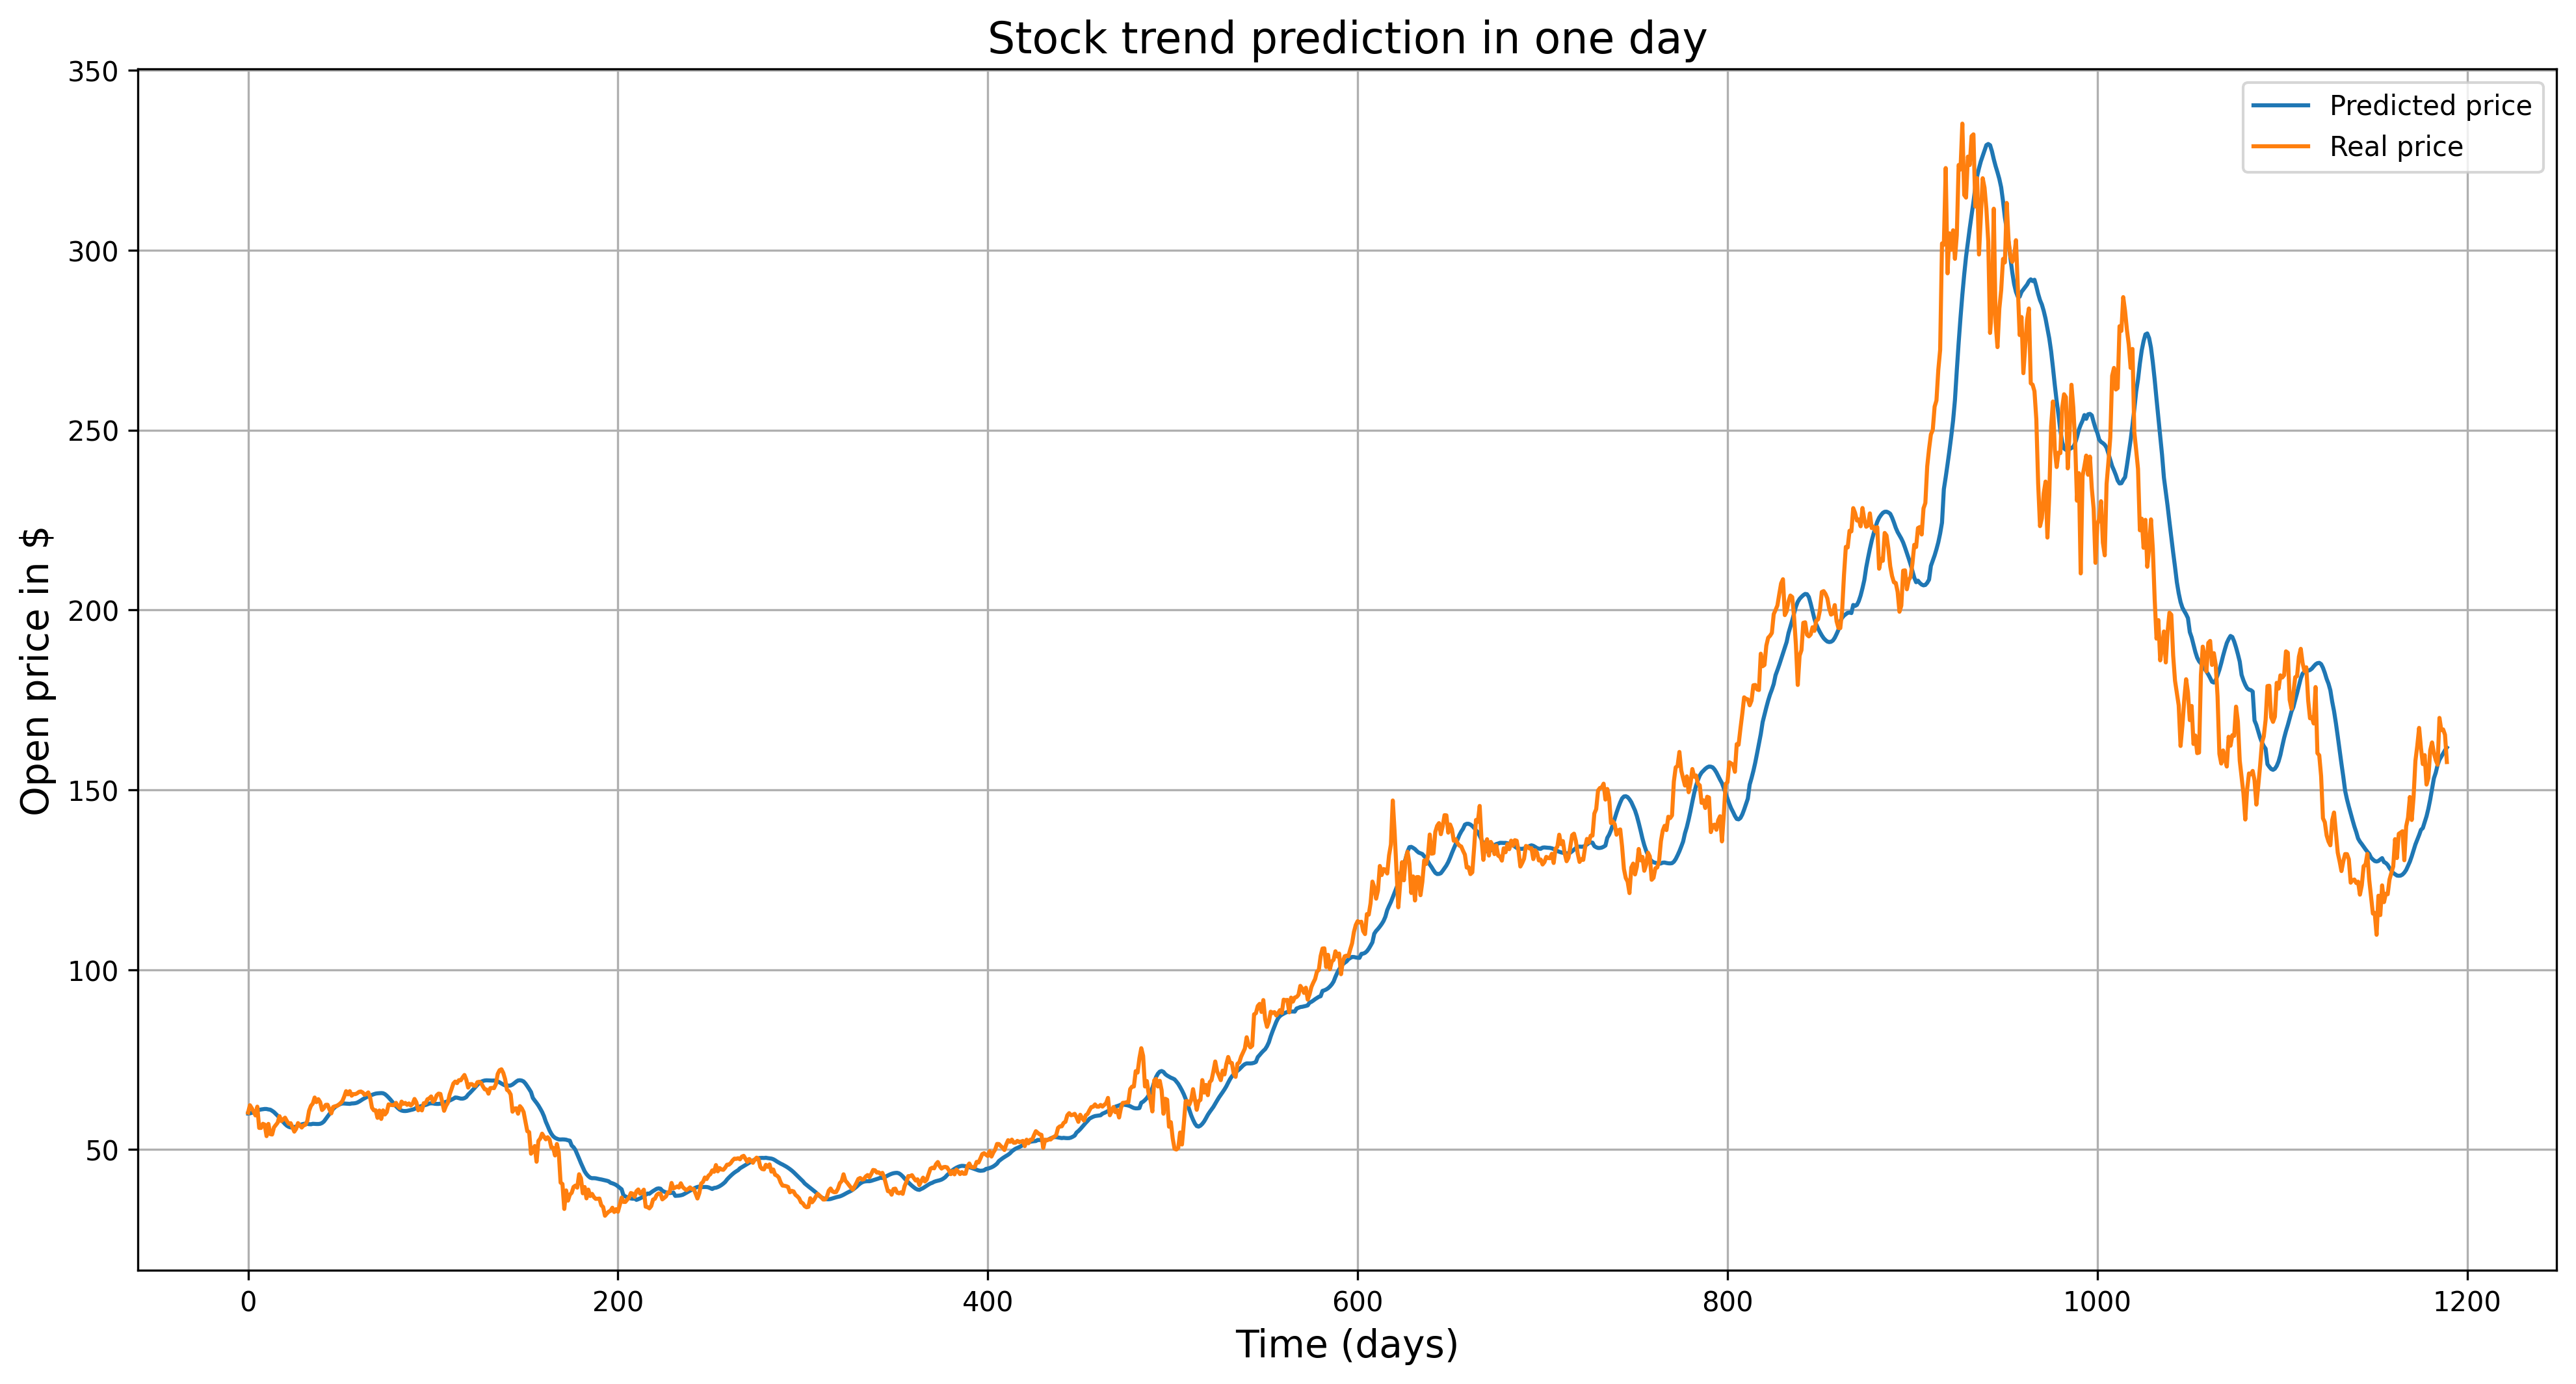

6/6 [==============================] - 1s 46ms/step
MSE on the test set:  0.05788760879692795


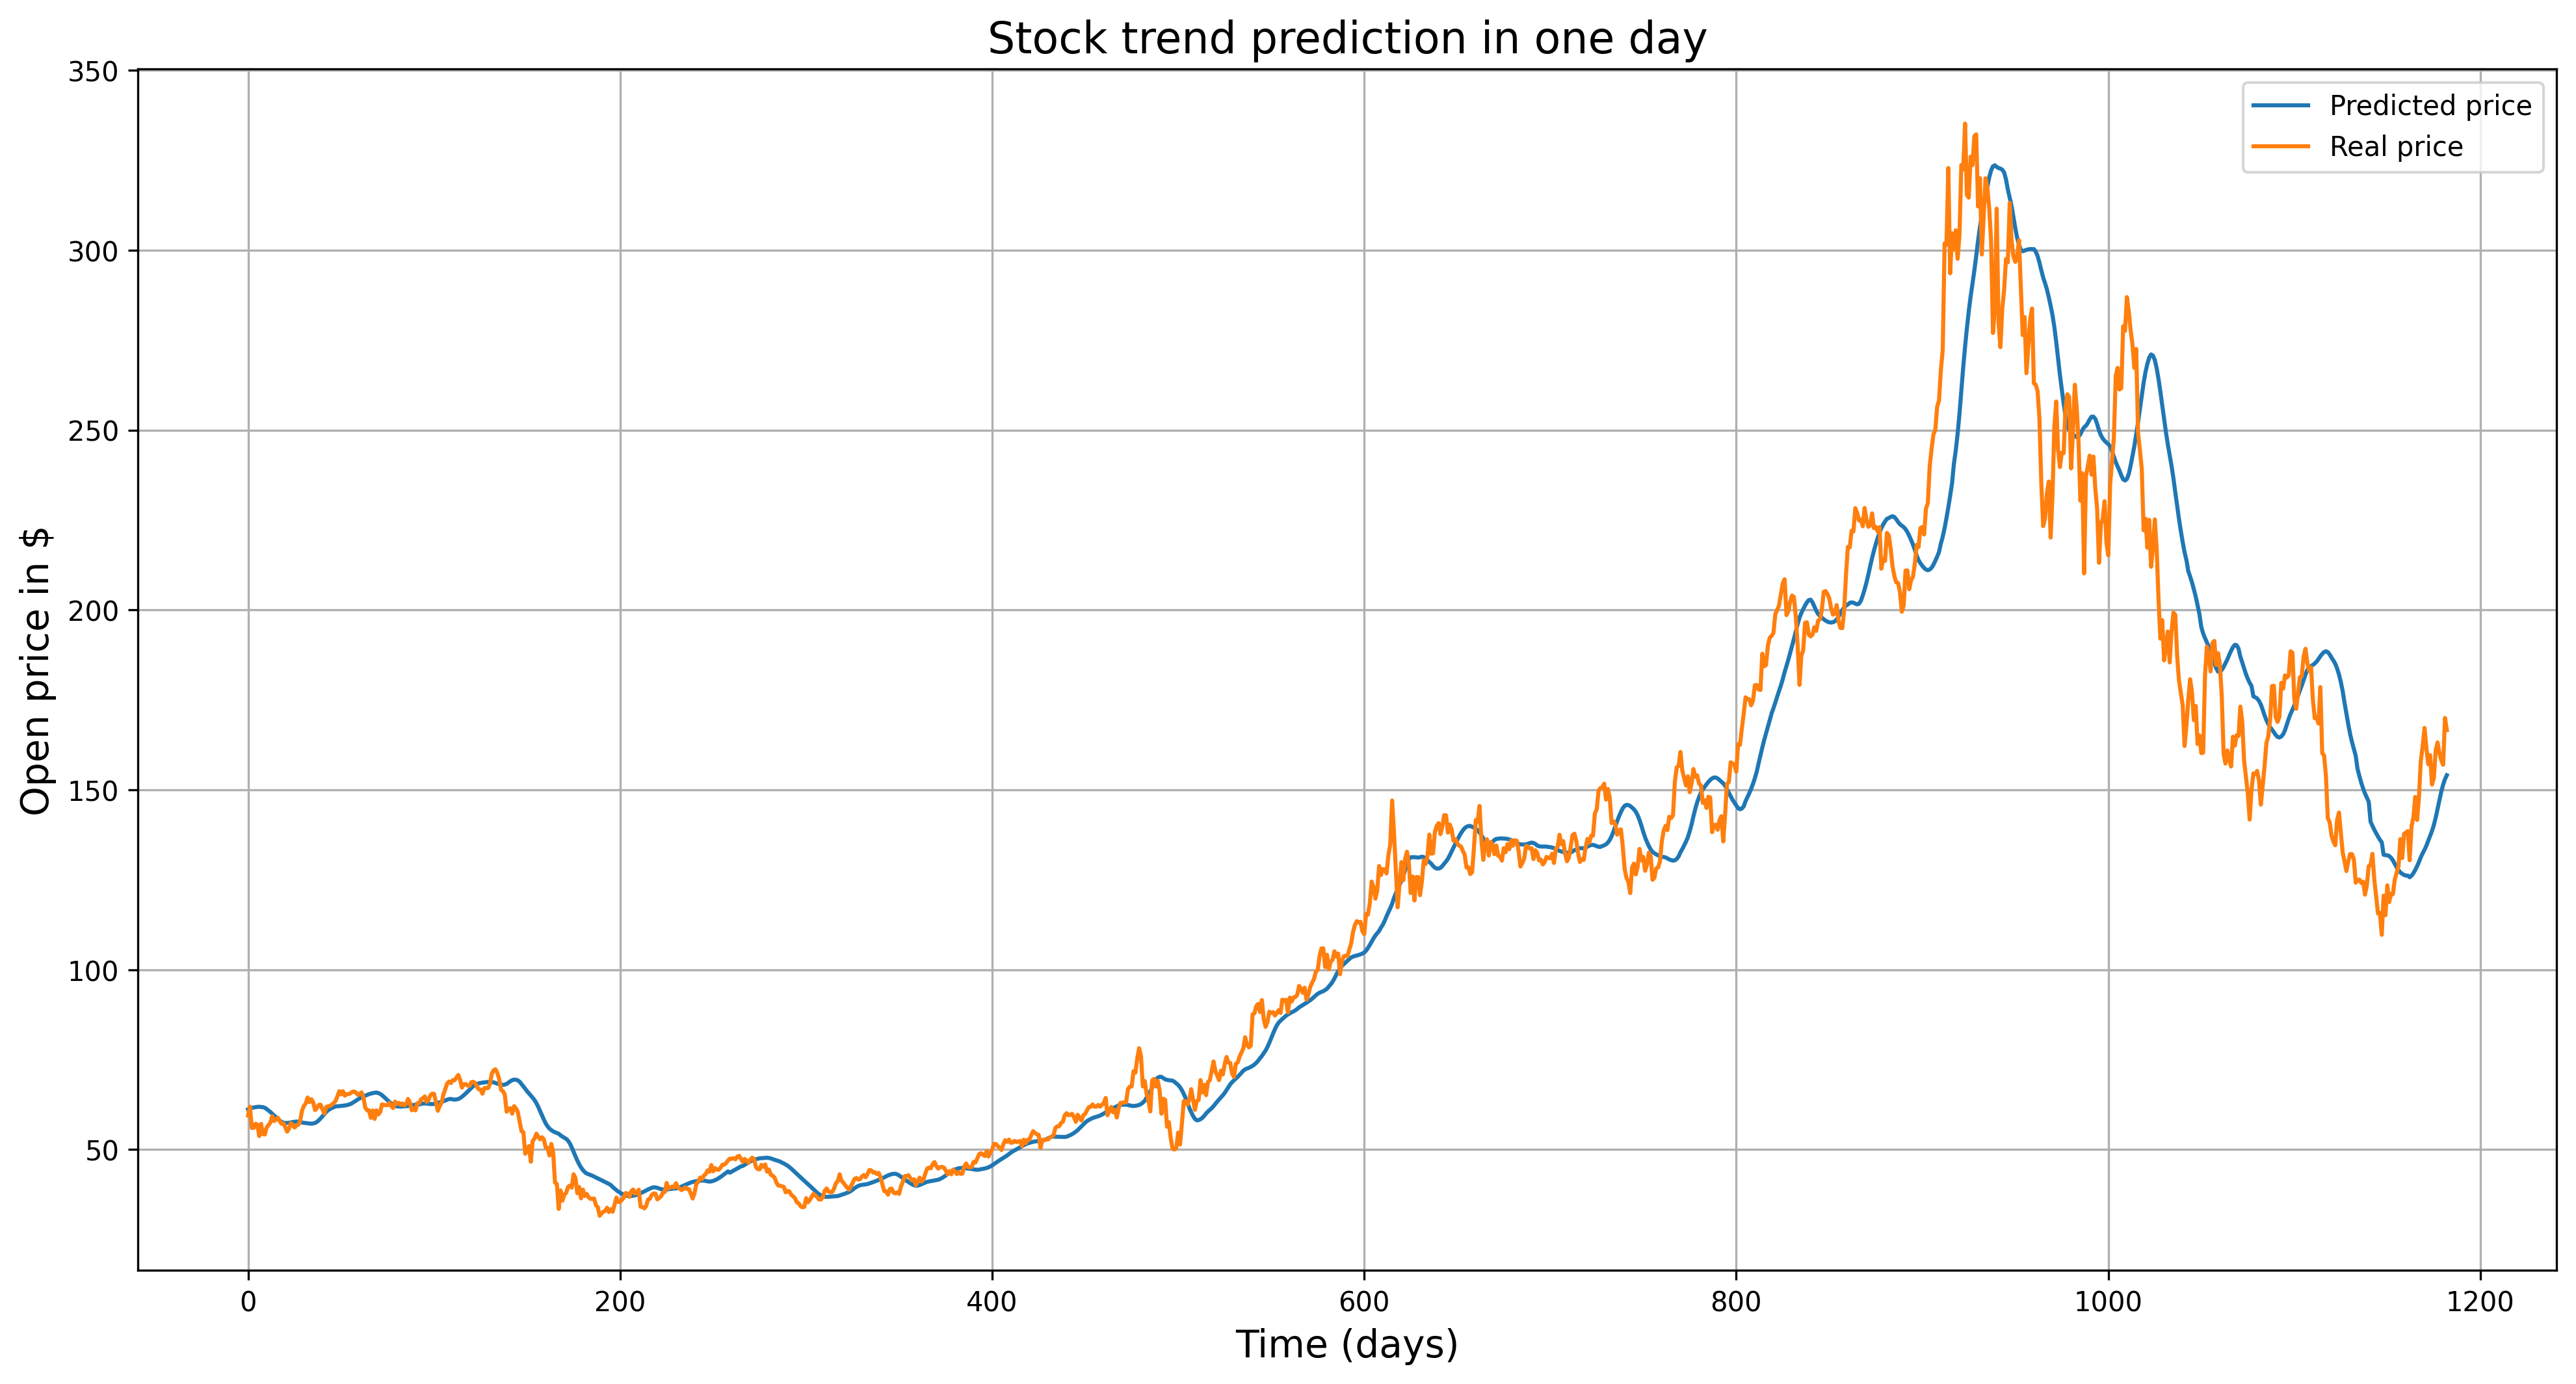

In [557]:
for window_size in window_sizes: 
    #Run prediction for 30 days and predict the next 7 days
    X, y = get_samples(sample, window_size, feat = "open", target_pred = pred_time)
    X_train, X_test, X_val, y_train, y_test, y_val = preprocessing(X, y, window_size)
    X_train_norm, y_train_norm = norm_data(X_train, y_train)
    X_val_norm, y_val_norm = norm_data(X_val, y_val)
    model, val_loss, val_mse = train_model(X_train_norm, y_train_norm, X_val_norm, y_val_norm, window_size, pred_time)
    models.append(model)
    val_MSEs.append(val_mse)
    val_losses.append(val_loss)
    test_mse = test_model(model, X_test, y_test, plot=True)
    test_MSEs.append(test_mse)

In [559]:
for i in range(len(window_sizes)):
    print("Prediction for 7 days with time window", window_sizes[i], "days")
    print("validation MSE: ", val_MSEs[i], "-", "val_loss:", val_losses[i])
    print("test MSE: ", test_MSEs[i])

Prediction for 7 days with time window 30 days
validation MSE:  0.2680392861366272 - val_loss: 0.2680392861366272
test MSE:  0.20683531219350865
Prediction for 7 days with time window 60 days
validation MSE:  0.11675182729959488 - val_loss: 0.11675182729959488
test MSE:  0.11503071208437919
Prediction for 7 days with time window 120 days
validation MSE:  0.06443630158901215 - val_loss: 0.06443630158901215
test MSE:  0.05788760879692795


In [580]:
#Save last model for reuse 
!mkdir -p saved_model
models[2].save('saved_model/NVDA')

INFO:tensorflow:Assets written to: saved_model/NVDA/assets


INFO:tensorflow:Assets written to: saved_model/NVDA/assets


In [581]:
saved_model = tf.keras.models.load_model('saved_model/NVDA')

# Check its architecture
saved_model.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 120, 128)          66560     
                                                                 
 dense_103 (Dense)           (None, 120, 1)            129       
                                                                 
 cropping1d_34 (Cropping1D)  (None, 7, 1)              0         
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


## Cross validation 

In [587]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [630]:
def cross_validate(company): 
    sample = load_data(company)
    window_size = 120
    pred_time = 7
    X, y = get_samples(sample, window_size, feat = "open", target_pred = pred_time)
    X, y = np.array(X), np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=0)
    X_train_norm, y_train_norm = norm_data(X_train, y_train)
    ensemble = []
    mses = []

    for n, (train_index, test_index) in enumerate(TimeSeriesSplit(n_splits=5).split(X_train, y_train)):
        print("On fold", n)
#         print("train_index", train_index , "test_index", test_index)
        X_val_fold, y_val_fold = X_train.copy()[test_index], y_train.copy()[test_index]
        X_train_fold, y_train_fold = X_train.copy()[train_index], y_train.copy()[train_index]
        X_train_fold_norm, y_train_fold_norm = norm_data(X_train_fold, y_train_fold)
        X_val_fold_norm, y_val_fold_norm = norm_data(X_val_fold, y_val_fold)

        # Print shape of the training, validation and test set
#         print("Shape of training set: ", X_train_fold.shape, y_train_fold.shape)
#         print("Shape of validation set: ", X_val_fold.shape, y_val_fold.shape)
#         print("Shape of test set:", X_test.shape, y_test.shape)

        # Create and train the model
        model, val_loss, val_mse = train_model(X_train_fold_norm, y_train_fold_norm, X_val_fold_norm, y_val_fold_norm, window_size, pred_time)
        ensemble.append(model)
        test_mse = test_model(model, X_test, y_test, verbose=0)
        mses.append(test_mse)
    overall_mse = np.average(mses)
    print("Overall MSE: ", overall_mse)
    # Pick best performing model to predict stock
    ensemble[np.argmin(mses)].save(filepath=save_path + company, include_optimizer=False)

In [631]:
cross_validate("NVDA")

On fold 0
MSE on the test set:  0.06150350933617205
On fold 1
MSE on the test set:  0.0579309338294184
On fold 2
MSE on the test set:  0.06305126993034632
On fold 3
MSE on the test set:  0.052216148954271305
On fold 4
MSE on the test set:  0.05548103844506735
Overall MSE:  0.05803658009905509


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/NVDA/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/NVDA/assets


## Use trained model to further train and predict for selected companies 

In [573]:
import os 
# Get the list of all files and directories 
# in the root directory 
path = 'data-nasdaq/csv/'
dir_list = os.listdir(path) 
# print("Files and directories in", path, ":") 

In [633]:
#Select 10 companies from NASDAQ 100 Technology Sector
company_list = ['ADSK', 'AAPL', 'FTNT', 'AMZN', 'MSFT', 'NXPI', 'QCOM', 'INTC', 'CTSH', 'MU'] 
#check if all companies in dir_list
for comp in company_list:
    file = comp + ".csv"
    print(file in dir_list)

True
True
True
True
True
True
True
True
True
True


In [634]:
for company in company_list:
    print("Train model and cross validation for:", company)
    cross_validate(company)

Train model and cross validation for: ADSK
On fold 0
MSE on the test set:  0.0659306628948131
On fold 1
MSE on the test set:  0.058626643513485614
On fold 2
MSE on the test set:  0.06034550214122446
On fold 3
MSE on the test set:  0.05855291354440156
On fold 4
MSE on the test set:  0.05622446325662385
Overall MSE:  0.059936037070109714


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/ADSK/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/ADSK/assets


Train model and cross validation for: AAPL
On fold 0
MSE on the test set:  0.05735248234162012
On fold 1
MSE on the test set:  0.04682845553962439
On fold 2
MSE on the test set:  0.045209024802471055
On fold 3
MSE on the test set:  0.042642503610814654
On fold 4
MSE on the test set:  0.041029757359360874
Overall MSE:  0.04661244473077822


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/AAPL/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/AAPL/assets


Train model and cross validation for: FTNT
On fold 0
MSE on the test set:  0.30678519239609564
On fold 1
MSE on the test set:  0.042396002963628214
On fold 2
MSE on the test set:  0.04844220832305423
On fold 3


MSE on the test set:  0.04373890464917774
On fold 4


MSE on the test set:  0.0440058741708868
Overall MSE:  0.09707363650056852


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/FTNT/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/FTNT/assets


Train model and cross validation for: AMZN
On fold 0
MSE on the test set:  0.0733011158812622
On fold 1
MSE on the test set:  0.06020842052244811
On fold 2
MSE on the test set:  0.05732105239998935
On fold 3
MSE on the test set:  0.05745158596494804
On fold 4
MSE on the test set:  0.058493722274889644
Overall MSE:  0.06135517940870747


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/AMZN/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/AMZN/assets


Train model and cross validation for: MSFT
On fold 0
MSE on the test set:  0.04203299255592253
On fold 1
MSE on the test set:  0.04433456407171244
On fold 2
MSE on the test set:  0.0442560563279577
On fold 3
MSE on the test set:  0.04044376804456624
On fold 4
MSE on the test set:  0.04063999863640951
Overall MSE:  0.04234147592731368


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/MSFT/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/MSFT/assets


Train model and cross validation for: NXPI
On fold 0
MSE on the test set:  0.12764195755247523
On fold 1
MSE on the test set:  0.05428463056246088
On fold 2
MSE on the test set:  0.05049811123378721
On fold 3
MSE on the test set:  0.05631375998556942
On fold 4
MSE on the test set:  0.056794171875275135
Overall MSE:  0.06910652624191357


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/NXPI/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/NXPI/assets


Train model and cross validation for: QCOM
On fold 0
MSE on the test set:  0.06430618361977683
On fold 1
MSE on the test set:  0.06743077415133973
On fold 2
MSE on the test set:  0.0636978703286182
On fold 3
MSE on the test set:  0.05963186234757954
On fold 4
MSE on the test set:  0.0592513075654171
Overall MSE:  0.06286359960254627


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/QCOM/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/QCOM/assets


Train model and cross validation for: INTC
On fold 0
MSE on the test set:  0.05716212115070602
On fold 1
MSE on the test set:  0.056865906531989426
On fold 2
MSE on the test set:  0.05576869905267632
On fold 3
MSE on the test set:  0.0508251547218798
On fold 4
MSE on the test set:  0.04877731130737082
Overall MSE:  0.05387983855292448


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/INTC/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/INTC/assets


Train model and cross validation for: CTSH
On fold 0
MSE on the test set:  0.08400516571195338
On fold 1
MSE on the test set:  0.07653242395828445
On fold 2
MSE on the test set:  0.07369058230684292
On fold 3
MSE on the test set:  0.07079413574883452
On fold 4
MSE on the test set:  0.07048679836255028
Overall MSE:  0.07510182121769311


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/CTSH/assets


INFO:tensorflow:Assets written to: saved_model/nasdaq_CV/CTSH/assets


Train model and cross validation for: MU
On fold 0


/var/folders/gk/fvlxt4n12ldf5rf0ycgz750h0000gn/T/ipykernel_18709/1784921158.py:61: RuntimeWarning: invalid value encountered in divide
  X_norm[i] = (X[i] - min_feature) / (max_feature - min_feature)
/var/folders/gk/fvlxt4n12ldf5rf0ycgz750h0000gn/T/ipykernel_18709/1784921158.py:62: RuntimeWarning: invalid value encountered in divide
  y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)
/var/folders/gk/fvlxt4n12ldf5rf0ycgz750h0000gn/T/ipykernel_18709/1784921158.py:62: RuntimeWarning: divide by zero encountered in divide
  y_norm[i] = (y[i] - min_feature) / (max_feature - min_feature)


ValueError: Input contains NaN.